# Scenario 3: Initial rate analysis with and without Tween
Dataset provided by Alexander Behr, Julia Grühn and Katrin Rosenthal (Department of Biochemical and ChemicalEngineering, TU Dortmund University, Dortmund, Germany)  
  
The aim of the initial rate analysis is to investigate the influence of Tween 80 on the oxidation of ABTS by Trametes versicolor laccase. The dataset contains measurements of the product concentration for different initial substrate concentrations, first with 1% Tween 80, then without Tween 80. The experiment was conducted in a straight tube reactor. In the course of the project experiments in a spiral tube reactor should be conducted, those will only contain two data points per measurement, one at the beginning and one at the end of the reactor. In the absence of time-course data only initial rate analysis can be performed. In preparation for this, only initial rate analysis is done in this scenario.

## Imports
First all necessary Python packages must be installed and imported.  
This step is the same for all scenarios and differs only in the used python packages.
If you run this notebook with Binder you don't have to install anything, Binder takes care of this.   
If you run this notebook local make sure you have all Packages installed. All needed packages with the used version can be found in the `requirements.txt` in the root GitHub directory (not in `\book`).

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

from scipy import stats
from lmfit import minimize, Parameters, report_fit

from pyenzyme import EnzymeMLDocument

## Reading EnzymeML with PyEnzyme software
In order to read the EnzymeML document and access its content with the PyEnzyme software the file path is defined.  
If you want to run this Jupyter Notebook locally, make sure you have the same folder structure or to change the path accordingly.  
When running the next code cell the EnzymeML document is saved in the `enzmlDoc` variable and an overview is printed below.

In [2]:
path = '../../data/Rosenthal_Measurements_orig.omex'

# check for correct file path and file extension:
if os.path.isfile(path) and os.path.basename(path).lower().endswith('.omex'):
    enzmlDoc = EnzymeMLDocument.fromFile(path)
    enzmlDoc.printDocument(measurements=True)
else:
    raise FileNotFoundError(
        f'Couldnt find file at {path}.'
    )

Laccase_STR_Kinetic
>>> Reactants
	ID: s0 	 Name: ABTS reduced
	ID: s1 	 Name: oxygen
	ID: s2 	 Name: ABTS oxidized
	ID: s3 	 Name: Tween 80
>>> Proteins
	ID: p0 	 Name: Laccase
>>> Complexes
>>> Reactions
	ID: r0 	 Name: ABTS oxidation
>>> Measurements

ID    Species    Conc       Unit   
m0    p0        3.525     umole / l
m0    s0        36.450    umole / l
m0    s1        204       umole / l
m0    s2        0         umole / l
m0    s3        8.090     mmole / l
m1    p0        3.525     umole / l
m1    s0        91.130    umole / l
m1    s1        204       umole / l
m1    s2        0         umole / l
m1    s3        8.090     mmole / l
m2    p0        3.525     umole / l
m2    s0        182.260   umole / l
m2    s1        204       umole / l
m2    s2        0         umole / l
m2    s3        8.090     mmole / l
m3    p0        3.525     umole / l
m3    s0        364.510   umole / l
m3    s1        204       umole / l
m3    s2        0         umole / l
m3    s3        8.090    

The overview showed which reactant corresponds to which ID.  
Each measurement consists of 4 reactants and one protein (p0).
From the measurement information we can derive that the concentration of ABTS reduced (s0) and Tween 80 (s3) was varied.  
All concentrations, except for Tween, were given in the same units, therefore they don't have to be converted later on.  
Next one measurement is exemplarily examined. 

In [3]:
# Fetch the measurement and inspect the scheme
measurement = enzmlDoc.getMeasurement('m0')
measurement.printMeasurementScheme()

>>> Measurement m0: ABTS (1%) 1
    s0 | initial conc: 36.45 umole / l 	| #replicates: 0
    s1 | initial conc: 204.0 umole / l 	| #replicates: 0
    s2 | initial conc: 0.0 umole / l 	| #replicates: 2
    s3 | initial conc: 8.09 mmole / l 	| #replicates: 0
    p0 | initial conc: 3.525 umole / l 	| #replicates: 0


The measurement shows that only the product ABTS oxidized (s2) was measured.  
In this case, the two replicates per measurement correspond to one absorbance and one concentration measurement.

## Data preparation
In order to visualise and model the data, it first has to be extracted and prepared.  
All relevant data such as the initial concentrations and time-course data are extracted and saved for each measurement in a dictionary.  
The outer data-structure `dataDict` is a dictionary to distinguish between measurements with and without Tween 80.  
For convenient visualisation a second dictionary `visualisationData` contains only the time-course data.  
Since the absorbance has already been converted to concentration, only the concentration time-course data is extracted and modelled, for an easier comparison of the results.

In [4]:
#initialise data-structure to store experimental data
dataDict = {
    'tween': [],
    'noTween': []
}
visualisationData = {
    'tween': [],
    'noTween': []
}
# time and units
time = np.array(enzmlDoc.getMeasurement('m0').global_time, float)
timeUnit = enzmlDoc.getMeasurement('m0').global_time_unit
concentrationUnit = ''
# go through all measurements:
for measurement in enzmlDoc.measurement_dict.values():
    measurementData = {
        'p0': measurement.getProtein('p0').init_conc,
        's0': measurement.getReactant('s0').init_conc,
        's1': measurement.getReactant('s1').init_conc,
        's2': measurement.getReactant('s2').init_conc,
        's3': measurement.getReactant('s3').init_conc,
        'measured': []
    }
    
    # get replicates with time course data:
    reactant = measurement.getReactant('s2')
    concentrationUnit = reactant.unit
    
    for replicate in reactant.replicates:
        if replicate.data_type == 'conc':
            measurementData['measured'].append(replicate.data)
    # distinguish between measurements with and without tween
    if measurement.getReactant('s3').init_conc == 0.0:
        dataDict['noTween'].append(measurementData)
        visualisationData['noTween'].append(measurementData['measured'])
    else:
        dataDict['tween'].append(measurementData)
        visualisationData['tween'].append(measurementData['measured'])

## Visualisation of time-course data
All time-course data extracted from the measurements is visualised with the Python library matplotlib.

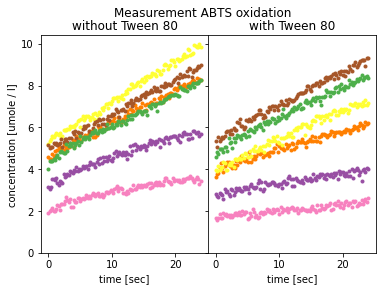

In [5]:
# define colors for all visualisations
colors = ['#f781bf','#984ea3','#ff7f00','#ffff33','#a65628','#4daf4a']
reaction_name = enzmlDoc.getReaction('r0').name
# plot time course data with matplotlib
fig = plt.figure()
gs = fig.add_gridspec(1, 2, wspace = 0)
(ax1, ax2) = gs.subplots(sharey = True)
fig.suptitle('Measurement '+reaction_name)
for i in range(len(visualisationData['tween'])):
    ax1.plot(time, visualisationData['noTween'][i][0], 'o', ms=3, color = colors[i])
    ax1.set(title = 'without Tween 80', xlabel = 'time ['+timeUnit+']', ylabel = 'concentration ['+concentrationUnit+']')
    ax2.plot(time, visualisationData['tween'][i][0], 'o', ms=3, color = colors[i])
    ax2.set(title = 'with Tween 80', xlabel = 'time ['+timeUnit+']')
ax1.set_ylim(ymin=0)
ax2.set_ylim(ymin=0)
# save as svg
# plt.savefig('time-course.svg', bbox_inches='tight')
plt.show()

The visualisation shows that the time-course data for the product does not start at 0, as it is stated in the EnzymeML document in the initial concentration field. This indicates that either the measurement did not start immediately and a part of the substrate was already converted, or only the linear part was transferred from the original data into the EnzymeML document.

## Computation of initial rates
Initial rates for the different substrate concentrations are calculated with linear regression by the Python library SciPy and added to the `allData` dictionary.  
Simultaneously the curves from the linear regression are plotted together with the measurements to get a visual impression of the goodness of the fit.  
Here the regression was done over the whole time-course including all available data-points. Alternatively only a part could have been defined for the linear regression as was done in [Scenario 2](./Scenario2.ipynb).

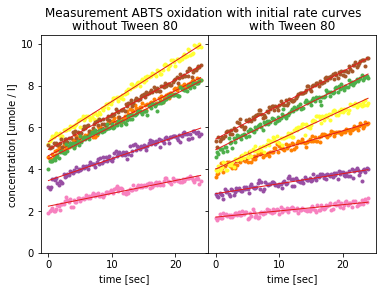

In [6]:
# Function returning a curve with the initial rate as the slope for visualisation
def initialRateCurve(time, slope, intercept):
    curve = slope*time+intercept
    return curve

# Visualisation
fig = plt.figure()
gs = fig.add_gridspec(1, 2, wspace = 0)
(ax1, ax2) = gs.subplots(sharey = True)
fig.suptitle('Measurement '+reaction_name+' with initial rate curves')
i = 0
for measurementData in dataDict['noTween']:
    # computation of initial rates with linear regression
    slope, intercept, r, p, se = stats.linregress(time, measurementData['measured'][0])
    measurementData['v'] = slope
    # visualisation of time-course data and initial rate curves
    ax1.plot(time, measurementData['measured'][0], 'o', ms=3, color = colors[i])
    ax1.plot(time, initialRateCurve(time, slope, intercept), '-', linewidth=1, color='#e31a1c')
    ax1.set(title = 'without Tween 80', xlabel = 'time ['+timeUnit+']', ylabel = 'concentration ['+concentrationUnit+']')
    i += 1
i = 0
for measurementData in dataDict['tween']:
    # computation of initial rates with linear regression
    slope, intercept, r, p, se = stats.linregress(time, measurementData['measured'][0])
    measurementData['v'] = slope
    # visualisation of time-course data and initial rate curves
    ax2.plot(time, measurementData['measured'][0], 'o', ms=3, color = colors[i])
    ax2.plot(time, initialRateCurve(time, slope, intercept), '-', linewidth=1, color='#e31a1c')
    ax2.set(title = 'with Tween 80', xlabel = 'time ['+timeUnit+']')
    i += 1
ax1.set_ylim(ymin=0)
ax2.set_ylim(ymin=0)
# save as svg
# plt.savefig('time-course_with_slope.svg', bbox_inches='tight')
plt.show()

### Plots of initial rates over ABTS concentrations.
For the modelling in the next step an additional data point for the substrate concentration of 0 is added. This data point is trivial but can help with the fit, since this is an exact point without errors.

In [7]:
measurementData = dataDict['noTween'][0]
measurementDataNew = {
        'p0': measurementData['p0'],
        's0': 0.0,
        's1': measurementData['s1'],
        's2': measurementData['s2'],
        's3': measurementData['s3'],
        'v': 0.0,
        'measured': []
    }
dataDict['noTween'].insert(0,measurementDataNew)
measurementData = dataDict['tween'][0]
measurementDataNew = {
        'p0': measurementData['p0'],
        's0': 0.0,
        's1': measurementData['s1'],
        's2': measurementData['s2'],
        's3': measurementData['s3'],
        'v': 0.0,
        'measured': []
    }
dataDict['tween'].insert(0,measurementDataNew)

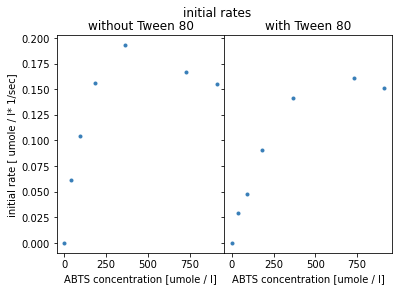

In [8]:
fig = plt.figure()
gs = fig.add_gridspec(1, 2, wspace = 0)
(ax1, ax2) = gs.subplots(sharey = True)
fig.suptitle('initial rates ')
for measurementData in dataDict['noTween']:
    ax1.plot(measurementData['s0'], measurementData['v'], 'o', ms=3, color='#377eb8')
    ax1.set(title = 'without Tween 80', ylabel ='initial rate [ '+concentrationUnit+'* 1/'+timeUnit+']', xlabel = 'ABTS concentration ['+concentrationUnit+']')
for measurementData in dataDict['tween']:
    ax2.plot(measurementData['s0'], measurementData['v'], 'o', ms=3, color='#377eb8')
    ax2.set(title = 'with Tween 80', xlabel = 'ABTS concentration ['+concentrationUnit+']')
# save as svg
# plt.savefig('initial-rates.svg', bbox_inches='tight')
plt.show()

Figure shows a optimum curve, with decreasing initial rates for higher substrate concentrations. For the experiment with Tween the optimum shifts to the right and initial rates are decreased for smaller substrate concentrations.

## Modelling and parameter estimation

In order to model the data and perform parameter fitting, the rate equations for the models are defined as Python functions, along with a function to calculate the residual between the models and the previously computed initial rates.  
In the following cell 2 different models are defined. First the irreversible Michaelis-Menten kinetic, which is often used in Biocatalysis for a first analysis. Katrin Rosenthal and her team also performed a Michaelis-Menten analysis with the Origin Pro software, which needs the initial rates as input, those were calculated in Excel.   
The standard irreversible Michaelis-Menten kinetic results in a saturation curve. Therefore, an extension of the Michaelis-Menten kinetic with substrate inhibition was implemented.  
The two extensions were derived from the article TODO add citation! on [The Science Snail](https://www.sciencesnail.com/science/a-generalized-model-for-enzymatic-substrate) website. Since no inhi
All models can be fitted either with v_max as a parameter or k_cat.

In [9]:
def irreversibleMichaelisMenten(kineticVariables, parameters):
    '''
    Rate equation according to Michaelis-Menten, with the Michaelis-Menten constant K_M and k_cat as as parameters
    Arguments:
        kineticVariables: vector of variables: kineticVariables = [s0, p0]
        parameters: parameters object from lmfit
    '''
    # ABTS:
    s0 = kineticVariables[0]
    # Enzyme:
    p0 = kineticVariables[1]

    #k_cat = parameters['k_cat'].value
    v_max = parameters['v_max'].value
    K_M = parameters['K_M'].value

    #v = k_cat*p0*s0/(K_M+s0)
    v = v_max*s0/(K_M+s0)

    return v

def michaelisMentenWithSubstrateInhibition(kineticVariables, parameters): 
    '''
    TODO V1 RAUS nur V2 behalten!!!!!!!!!!!
    Rate equation extending Michaelis-Menten, with substrate inhibition introducing an additional inhibition parameter K_i
    From https://www.sciencesnail.com/science/a-generalized-model-for-enzymatic-substrate equation with K_M^app
    Arguments:
        kineticVariables: vector of variables: kineticVariables = [s0, p0]
        parameters: parameters object from lmfit
    '''
    # ABTS:
    s0 = kineticVariables[0]
    # Enzyme:
    p0 = kineticVariables[1]

    #k_cat = parameters['k_cat'].value
    v_max = parameters['v_max'].value
    K_M = parameters['K_M'].value
    K_i = parameters['K_i']

    #v = k_cat*p0*s0/(K_M*(1+s0/K_i)+s0)
    v = v_max*s0/(K_M*(1+s0/K_i)+s0)

    return v

def michaelisMentenWithSubstrateInhibitionV2(kineticVariables, parameters):
    '''
    Rate equation extending Michaelis-Menten, with substrate inhibition introducing an additional inhibition parameter K_i
    From https://www.sciencesnail.com/science/a-generalized-model-for-enzymatic-substrate equation with V_max^app
    Arguments:
        kineticVariables: vector of variables: kineticVariables = [s0, p0]
        parameters: parameters object from lmfit
    '''
    # ABTS:
    s0 = kineticVariables[0]
    # Enzyme:
    p0 = kineticVariables[1]

    #k_cat = parameters['k_cat'].value
    v_max = parameters['v_max'].value
    K_M = parameters['K_M'].value
    K_i = parameters['K_i']

    #v = k_cat*p0*s0/((K_M+s0)*(1+s0/K_i))
    v = v_max*s0/((K_M+s0)*(1+s0/K_i))

    return v

def residual(parameters, tween: str, kineticEquation):
    '''
    Residual function to compute difference between the model, defined in the kineticEquation and the computed initial rates.
    Arguments:
        parameters: parameters object from lmfit
        tween: key to select data with or without Tween 80
        kineticEquation: function defining the kinetc model
    '''
    measurementsData = dataDict[tween]
    residual = [0.0]*len(measurementsData)
    for i in range(len(measurementsData)):
        measurementData = measurementsData[i]
        v_modeled = kineticEquation([measurementData['s0'],measurementData['p0']], parameters)
        residual[i]=measurementData['v']-v_modeled
    return residual

For each modelling step the a parameters object from the Python library lmfit is initialised.

In [10]:
params = Parameters()
#params.add('k_cat', value=0.6, min=0.0001, max=1000)
params.add('v_max', value=0.6, min=0.0001, max=1000)
params.add('K_M', value=100, min=0.0001, max=10000)

resultsMichaelisMentenNoTween = minimize(residual, params, args=('noTween', irreversibleMichaelisMenten), method='leastsq')
resultsMichaelisMentenTween = minimize(residual, params, args=('tween', irreversibleMichaelisMenten), method='leastsq')

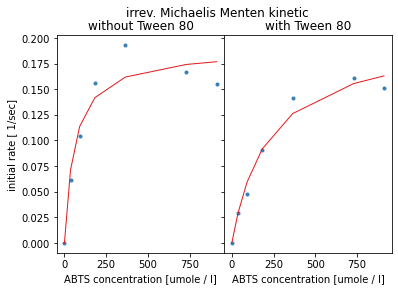

In [11]:
fig = plt.figure()
gs = fig.add_gridspec(1, 2, wspace = 0)
(ax1, ax2) = gs.subplots(sharey = True)
fig.suptitle('irrev. Michaelis-Menten kinetic ')
sNoTween = []
sTween = []
vNoTween = []
vTween = []
for measurementData in dataDict['noTween']:
    ax1.plot(measurementData['s0'], measurementData['v'], 'o', ms=3, color='#377eb8')
    sNoTween.append(measurementData['s0'])
    vNoTween.append(irreversibleMichaelisMenten([measurementData['s0'],measurementData['p0']], resultsMichaelisMentenNoTween.params))
    ax1.set(title = 'without Tween 80', ylabel ='initial rate [ 1/'+timeUnit+']', xlabel = 'ABTS concentration ['+concentrationUnit+']')
for measurementData in dataDict['tween']:
    ax2.plot(measurementData['s0'], measurementData['v'], 'o', ms=3, color='#377eb8')
    sTween.append(measurementData['s0'])
    vTween.append(irreversibleMichaelisMenten([measurementData['s0'],measurementData['p0']], resultsMichaelisMentenTween.params))
    ax2.set(title = 'with Tween 80', xlabel = 'ABTS concentration ['+concentrationUnit+']')
ax1.plot(sNoTween, vNoTween, '-', linewidth=1, color='#e31a1c')
ax2.plot(sTween, vTween, '-', linewidth=1, color='#e31a1c')
# save as svg
# plt.savefig('initial-rates_irrev_Michaelis_Menten.svg', bbox_inches='tight')
plt.show()

### Results for measurements without Tween

In [12]:
resultsMichaelisMentenNoTween

### Results for measurements with Tween

In [13]:
resultsMichaelisMentenTween

### With substrate dependent enzyme inhibition (Version 1)

In [16]:
params = Parameters()
#params.add('k_cat', value=0.06, min=0.000001, max=1000)
params.add('v_max', value=0.6, min=0.0001, max=1000)
params.add('K_M', value=80, min=0.000001, max=10000)
params.add('K_i', value=160, min=0.000001, max=10000)

resultsSubstrateInhibitionNoTween = minimize(residual, params, args=('noTween', michaelisMentenWithSubstrateInhibition), method='leastsq')
resultsSubstrateInhibitionTween = minimize(residual, params, args=('tween', michaelisMentenWithSubstrateInhibition), method='leastsq')

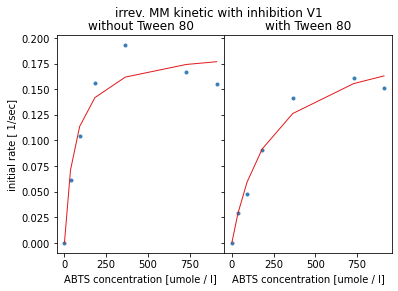

In [17]:
fig = plt.figure()
gs = fig.add_gridspec(1, 2, wspace = 0)
(ax1, ax2) = gs.subplots(sharey = True)
fig.suptitle('irrev. MM kinetic with inhibition V1')
sNoTween = []
sTween = []
vNoTween = []
vTween = []
for measurementData in dataDict['noTween']:
    ax1.plot(measurementData['s0'], measurementData['v'], 'o', ms=3, color='#377eb8')
    sNoTween.append(measurementData['s0'])
    vNoTween.append(michaelisMentenWithSubstrateInhibition([measurementData['s0'],measurementData['p0']], resultsSubstrateInhibitionNoTween.params))
    ax1.set(title = 'without Tween 80', ylabel ='initial rate [ 1/'+timeUnit+']', xlabel = 'ABTS concentration ['+concentrationUnit+']')
for measurementData in dataDict['tween']:
    ax2.plot(measurementData['s0'], measurementData['v'], 'o', ms=3, color='#377eb8')
    sTween.append(measurementData['s0'])
    vTween.append(michaelisMentenWithSubstrateInhibition([measurementData['s0'],measurementData['p0']], resultsSubstrateInhibitionTween.params))
    ax2.set(title = 'with Tween 80', xlabel = 'ABTS concentration ['+concentrationUnit+']')
ax1.plot(sNoTween, vNoTween, '-', linewidth=1, color='#e31a1c')
ax2.plot(sTween, vTween, '-', linewidth=1, color='#e31a1c')
# save as svg
# plt.savefig('initial-rates_irrev_Michaelis_Menten_inhibitionV1.svg', bbox_inches='tight')
plt.show()

In [18]:
report_fit(resultsSubstrateInhibitionNoTween)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 7
    # variables        = 3
    chi-square         = 0.00188835
    reduced chi-square = 4.7209e-04
    Akaike info crit   = -51.5257279
    Bayesian info crit = -51.6879975
##  Warning: uncertainties could not be estimated:
[[Variables]]
    v_max:  0.23998253 +/-        nan (nan%) (init = 0.6)
    K_M:    76.4352495 +/-        nan (nan%) (init = 80)
    K_i:    279.895535 +/-        nan (nan%) (init = 160)


In [19]:
resultsSubstrateInhibitionTween

### With substrate dependent enzyme inhibition (Version 2)

In [20]:
params = Parameters()
#params.add('k_cat', value=0.06, min=0.000001, max=1000)
params.add('v_max', value=0.6, min=0.0001, max=1000)
params.add('K_M', value=80, min=0.000001, max=10000)
params.add('K_i', value=160, min=0.000001, max=10000)

resultsSubstrateInhibitionNoTweenV2 = minimize(residual, params, args=('noTween', michaelisMentenWithSubstrateInhibitionV2), method='leastsq')
resultsSubstrateInhibitionTweenV2 = minimize(residual, params, args=('tween', michaelisMentenWithSubstrateInhibitionV2), method='leastsq')

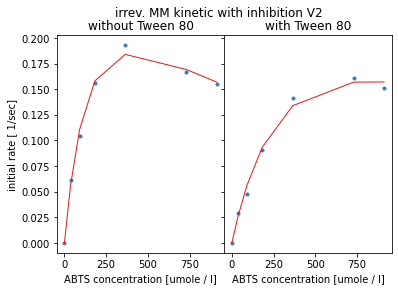

In [21]:
fig = plt.figure()
gs = fig.add_gridspec(1, 2, wspace = 0)
(ax1, ax2) = gs.subplots(sharey = True)
fig.suptitle('irrev. MM kinetic with inhibition V2')
sNoTween = []
sTween = []
vNoTween = []
vTween = []
for measurementData in dataDict['noTween']:
    ax1.plot(measurementData['s0'], measurementData['v'], 'o', ms=3, color='#377eb8')
    sNoTween.append(measurementData['s0'])
    vNoTween.append(michaelisMentenWithSubstrateInhibitionV2([measurementData['s0'],measurementData['p0']], resultsSubstrateInhibitionNoTweenV2.params))
    ax1.set(title = 'without Tween 80', ylabel ='initial rate [ 1/'+timeUnit+']', xlabel = 'ABTS concentration ['+concentrationUnit+']')
for measurementData in dataDict['tween']:
    ax2.plot(measurementData['s0'], measurementData['v'], 'o', ms=3, color='#377eb8')
    sTween.append(measurementData['s0'])
    vTween.append(michaelisMentenWithSubstrateInhibitionV2([measurementData['s0'],measurementData['p0']], resultsSubstrateInhibitionTweenV2.params))
    ax2.set(title = 'with Tween 80', xlabel = 'ABTS concentration ['+concentrationUnit+']')
ax1.plot(sNoTween, vNoTween, '-', linewidth=1, color='#e31a1c')
ax2.plot(sTween, vTween, '-', linewidth=1, color='#e31a1c')
# save as svg
# plt.savefig('initial-rates_irrev_Michaelis_Menten_inhibitionV2.svg', bbox_inches='tight')
plt.show()

In [22]:
resultsSubstrateInhibitionNoTweenV2

In [23]:
resultsSubstrateInhibitionTweenV2